In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../lib')

pd.set_option('display.max_columns', 500)

from datetime import datetime
from numpy import inf
from math import prod
from IPython.display import clear_output

from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from scipy.stats import kstest

# Конфиг
from model_functions import *
from model_features import *
from model_metrics import *

# Для автообновления конфига
%load_ext autoreload
%autoreload 2

### 1. Подготовка

#### Данные

Используем поквартальные данные по тем показателям, которые **прогнозируются Банком РФ и Минэкономразвития**

In [2]:
data=pd.read_excel('../data/data_train.xlsx',sheet_name='data')
descriptions=pd.read_excel('../data/data_train.xlsx',sheet_name='description')

#### Пропуски

In [3]:
drop_feat=[]
for c in data.columns:
    if data[c].isna().sum()>10:
        drop_feat.append(c)
        
data_model=data.drop(drop_feat,axis=1)
print(f'Удалили признаки: {drop_feat}')

Удалили признаки: ['vi_mining', 'vi_industry']


#### Лишние признаки

Удалим сальдовые признаки

In [4]:
saldo_feat=[c for c in data_model.columns if 'saldo' in c]
data_model=data_model.drop(saldo_feat,axis=1)
print(f'Удалили признаки: {saldo_feat}')

Удалили признаки: ['saldo_stp_sok', 'saldo_fin']


#### Классификация признаков

Делим признаки на три группы:
1. Процентные признаки (для них ничего делать не будем);
2. Индексные признаки (их приведём к приростам, отняв 100%);
3. Количественные признаки (для них рассчитаем приросты).

In [5]:
percent_features=['unempl_rate','int_rate']
index_features=['cpi','vi_mining','vi_industry']
count_features=[x for x in data_model.drop('period',axis=1) if x not in (percent_features+index_features)]

### 2. Генерация признаков

Все признаки и таргет приведём к темпам прироста по следующим причинам:
1. Всё будет в одном масштабе, что хорошо для линейной регрессии (она не очень терпит диспропорции в размерах данных);
2. Сохраняется интерпретация (если для унификации масштаба делать нормализацию/стандартизацию, то теряется интерпретируемость);
3. Банк РФ/Минэкономразвития тоже прогнозирует в приростах.

Затем добавим 1-е лаги признаков

#### Темпы прироста

In [6]:
data_delta=pd.DataFrame()
# Сдвигаем период на 1 вперёд
data_delta['period']=data_model['period'][1:]
# Добавляем темпы прироста
for c in data_model.drop('period',axis=1).columns:
    if c in count_features:
        data_delta[c]=(data_model[c][1:].values/data_model[c][0:-1].values-1)*100
    elif c in index_features:
        data_delta[c]=data_model[c]-100
    else:
        data_delta[c]=data_model[c]

#### Лаги

In [7]:
data_lag=pd.DataFrame()
# Сдвигаем период на 1 вперёд относительно data_delta
data_lag['period']=data_delta['period'][1:]
# Добавляем лаги
for c in data_delta.drop('period',axis=1).columns:
    data_lag[f'l1_{c}']=data_delta[c][:-1].values

#### Объединяем

In [8]:
dataset=pd.merge(data_lag,data_delta,on='period').drop(['debt_rub','l1_debt_rub'],axis=1)
# Список признаков
feature_list=dataset.drop(['period','target'],axis=1).columns
target='target'
print(f'Число наблюдений: {len(dataset)}, число признаков: {len(feature_list)}')

Число наблюдений: 54, число признаков: 29


#### Обработаем Nan и inf

In [9]:
# Обрабатываем пропуски
dataset_lr=dataset.dropna()
# Обрабатываем inf
dataset_lr.replace([np.inf, -np.inf], 0, inplace=True)
# Выводим информацию
print(f'Число наблюдений после удаления пропусков: {len(dataset_lr)}')
print(f'Начальный период: {dataset_lr["period"].min()}')
print(f'Конечный период: {dataset_lr["period"].max()}')

Число наблюдений после удаления пропусков: 46
Начальный период: 2011-04-01 00:00:00
Конечный период: 2022-07-01 00:00:00


### 3. Линейная регрессия без "чёрных лебедей"

#### Датафреймы для заполнения

In [10]:
# Текущая дата
date_now=datetime.now()
# Квартальные прогнозы
try:
    quarter_predictions=pd.read_excel('Квартальные прогнозы.xlsx')
except:
    quarter_predictions=pd.DataFrame({'period':dataset_lr.period}).reset_index().drop('index',axis=1)
    quarter_predictions['y_true']=dataset_lr['target'].reset_index().drop('index',axis=1)
# Годовые прогнозы
try:
    year_predictions=pd.read_excel('Годовые прогнозы.xlsx')
except:
    year_predictions=pd.DataFrame({'year': range(2011,2023)})
# Метрики
try:
    metric_df=pd.read_excel('Метрики по годам.xlsx')
except:
    metric_df=pd.DataFrame(columns=['Модель','MAE','MAPE','MedianAE','MedianAPE','updated_dt'])

#### На всех признаках

,Train,Test,Relative Difference
MAE,0.66,2.20,2.33
MSE,0.65,6.53,9.05
MAPE,59.57,31.20,0.48


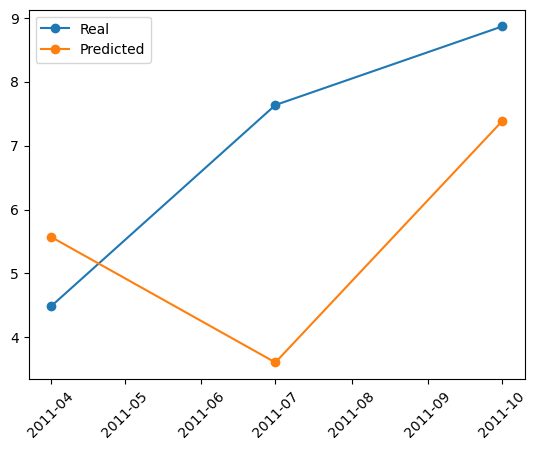

Реальный прирост за 2011 год: 22.43%
Прогнозный прирост за 2011 год: 17.45%



,Train,Test,Relative Difference
MAE,0.56,1.84,2.29
MSE,0.53,4.21,6.94
MAPE,41.34,26.14,0.37


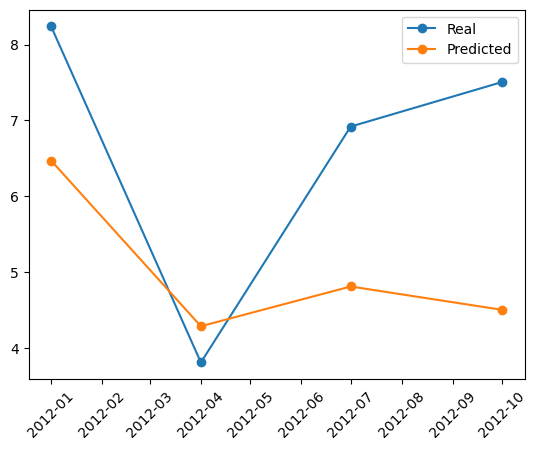

Реальный прирост за 2012 год: 29.15%
Прогнозный прирост за 2012 год: 21.61%



,Train,Test,Relative Difference
MAE,0.57,1.54,1.70
MSE,0.59,2.71,3.59
MAPE,45.83,39.45,0.14


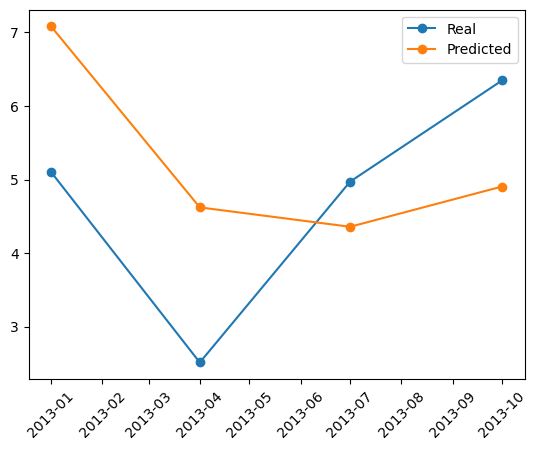

Реальный прирост за 2013 год: 20.28%
Прогнозный прирост за 2013 год: 22.65%



,Train,Test,Relative Difference
MAE,0.64,1.47,1.30
MSE,0.61,2.34,2.84
MAPE,52.46,48.57,0.07


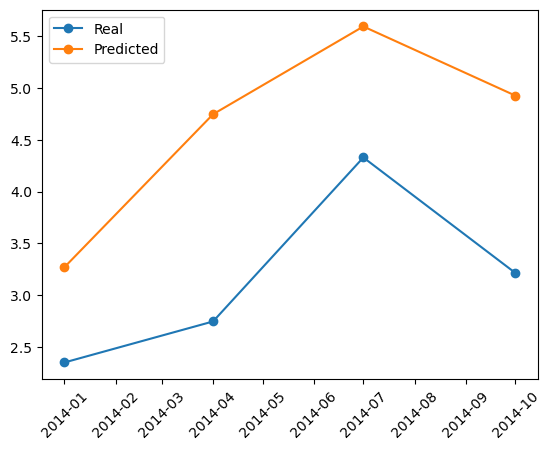

Реальный прирост за 2014 год: 13.25%
Прогнозный прирост за 2014 год: 19.85%



,Train,Test,Relative Difference
MAE,0.62,2.94,3.74
MSE,0.64,11.55,17.05
MAPE,33.55,934.50,26.85


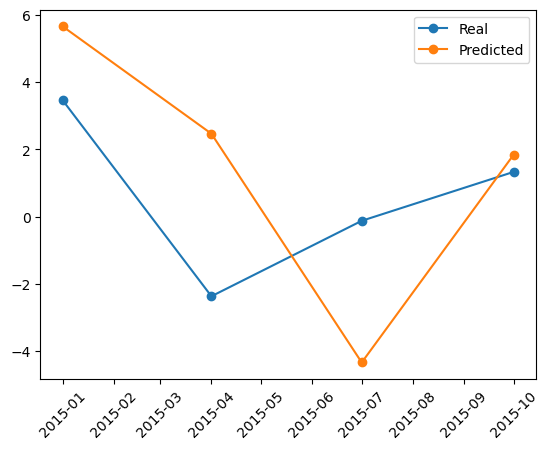

Реальный прирост за 2015 год: 2.23%
Прогнозный прирост за 2015 год: 5.48%



,Train,Test,Relative Difference
MAE,0.44,2.86,5.50
MSE,0.34,11.78,33.65
MAPE,16.39,846.87,50.67


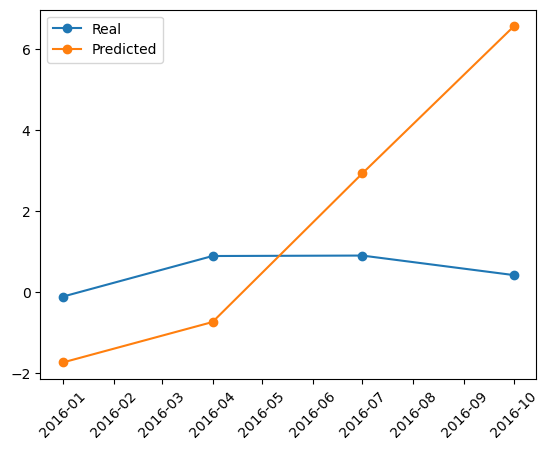

Реальный прирост за 2016 год: 2.14%
Прогнозный прирост за 2016 год: 7.01%



,Train,Test,Relative Difference
MAE,0.59,2.19,2.71
MSE,0.55,6.49,10.80
MAPE,42.38,127.44,2.01


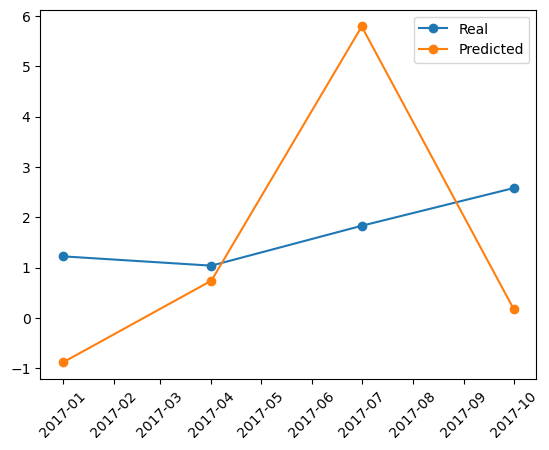

Реальный прирост за 2017 год: 6.84%
Прогнозный прирост за 2017 год: 5.82%



,Train,Test,Relative Difference
MAE,0.61,1.32,1.16
MSE,0.60,3.05,4.08
MAPE,56.48,37.04,0.34


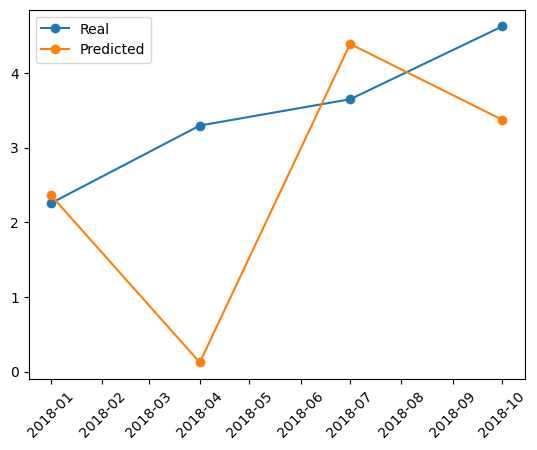

Реальный прирост за 2018 год: 14.54%
Прогнозный прирост за 2018 год: 10.59%



,Train,Test,Relative Difference
MAE,0.71,0.34,0.52
MSE,0.73,0.21,0.71
MAPE,57.61,11.41,0.80


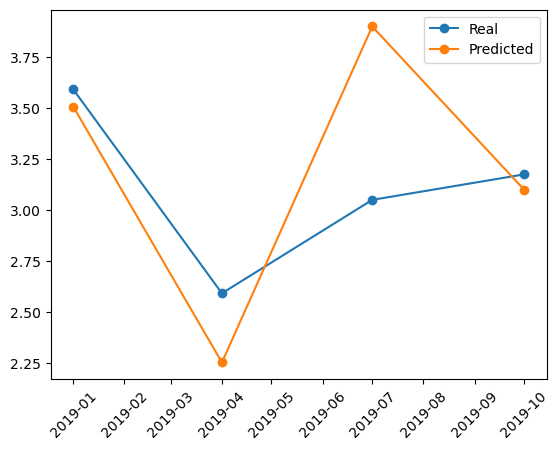

Реальный прирост за 2019 год: 12.99%
Прогнозный прирост за 2019 год: 13.37%



,Train,Test,Relative Difference
MAE,0.59,8.18,12.86
MSE,0.55,90.07,162.76
MAPE,38.33,334.90,7.74


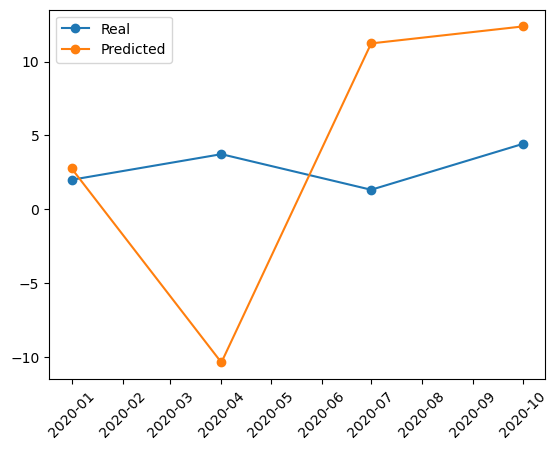

Реальный прирост за 2020 год: 11.97%
Прогнозный прирост за 2020 год: 15.16%



,Train,Test,Relative Difference
MAE,0.56,2.22,2.96
MSE,0.49,6.36,11.98
MAPE,58.68,51.00,0.13


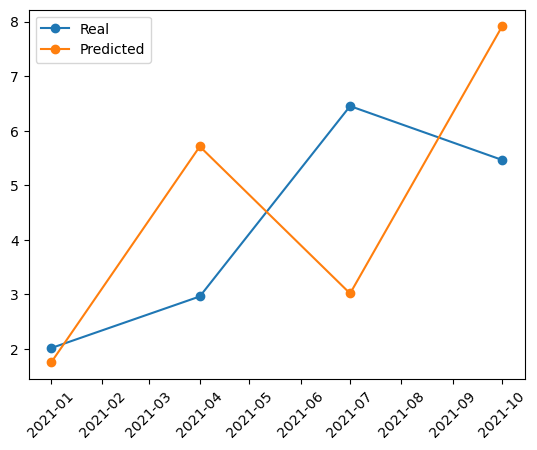

Реальный прирост за 2021 год: 17.92%
Прогнозный прирост за 2021 год: 19.57%



,Train,Test,Relative Difference
MAE,0.63,2.64,3.19
MSE,0.65,7.68,10.82
MAPE,47.18,83.61,0.77


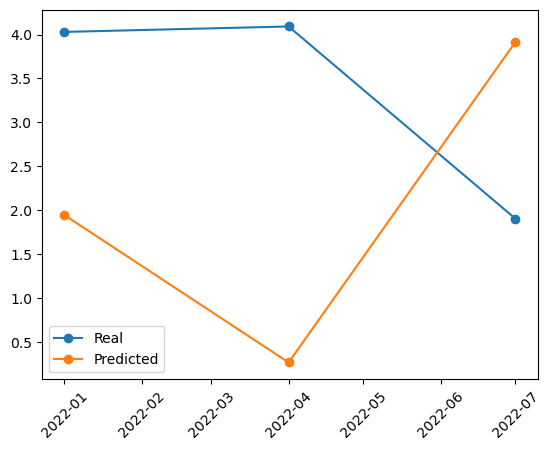

Реальный прирост за 2022 год: 10.35%
Прогнозный прирост за 2022 год: 6.21%

---------------------------------------------------------------------------
Средняя абсолютная ошибка по годовых прогнозам: 3.66%
Средняя относительная ошибка по годовых прогнозам: 50.27%
---------------------------------------------------------------------------
Медианная абсолютная ошибка по годовых прогнозам: 3.6%
Медианная относительная ошибка по годовых прогнозам: 26.25%
---------------------------------------------------------------------------


In [11]:
# Списки для заполнения
y_test_year_list=[]
y_test_pred_year_list=[]
quarter_pred_list=[]
# Прогоняем
for year in range(2011,2023):
    ## Выделяем train/test
    data_train=dataset_lr[(dataset_lr.period<f'{year}-01-01')|(dataset_lr.period>=f'{year}-12-31')]
    data_test=dataset_lr[(dataset_lr.period>=f'{year}-01-01')&(dataset_lr.period<f'{year}-12-31')]
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Добавляем для отчёта
    for pred in y_test_pred:
        quarter_pred_list.append(pred)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,y_test, label='Real',marker='o')
    plt.plot(data_test.period,y_test_pred, label='Predicted',marker='o')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()
    ## Агрегируем реальные и прогнозные значения
    y_test_year=prod(100+y_test)/(100**(len(y_test)-1))
    y_test_pred_year=prod(100+y_test_pred)/(100**(len(y_test_pred)-1))
    ## Добавляем в списки
    y_test_year_list.append(y_test_year-100)
    y_test_pred_year_list.append(y_test_pred_year-100)
    ## Выводим
    print(f'Реальный прирост за {year} год: {round((y_test_year-100),2)}%')
    print(f'Прогнозный прирост за {year} год: {round((y_test_pred_year-100),2)}%\n')
# Считаем метрики
mae=round(mean_absolute_error(y_test_year_list,y_test_pred_year_list),2)
mape=round(mean_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
medianae=round(median_absolute_error(y_test_year_list,y_test_pred_year_list),2)
medianape=round(median_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
# Итог
print('---------------------------------------------------------------------------')
print(f'Средняя абсолютная ошибка по годовых прогнозам: {mae}%')
print(f'Средняя относительная ошибка по годовых прогнозам: {mape}%')
print('---------------------------------------------------------------------------')
print(f'Медианная абсолютная ошибка по годовых прогнозам: {medianae}%')
print(f'Медианная относительная ошибка по годовых прогнозам: {medianape}%')
print('---------------------------------------------------------------------------')
# Формируем отчёт
metric_df.loc[len(metric_df)] = ['Линейная регрессия без отбора признаков и дамми-переменных',
                                 mae,mape,medianae,medianape,date_now]
year_predictions['y_true']=y_test_year_list
year_predictions['y_pred_linreg_full_nodummy']=y_test_pred_year_list
quarter_predictions['y_pred_linreg_full_nodummy']=quarter_pred_list

#### На отобранных признаках

,Train,Test,Relative Difference
MAE,0.88,1.66,0.89
MSE,1.19,3.23,1.71
MAPE,54.23,22.61,0.58


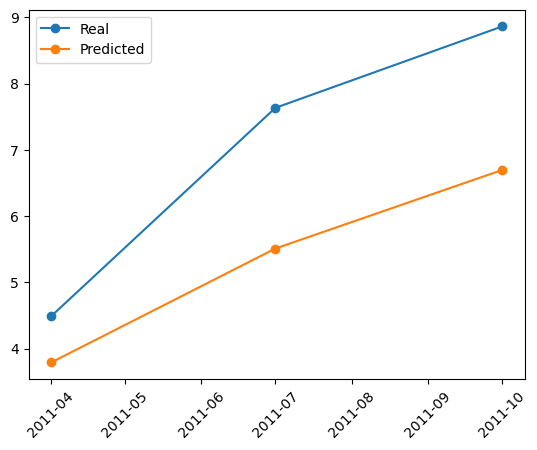

Реальный прирост за 2011 год: 22.43%
Прогнозный прирост за 2011 год: 16.84%



,Train,Test,Relative Difference
MAE,0.84,1.75,1.08
MSE,1.11,3.10,1.79
MAPE,52.00,28.11,0.46


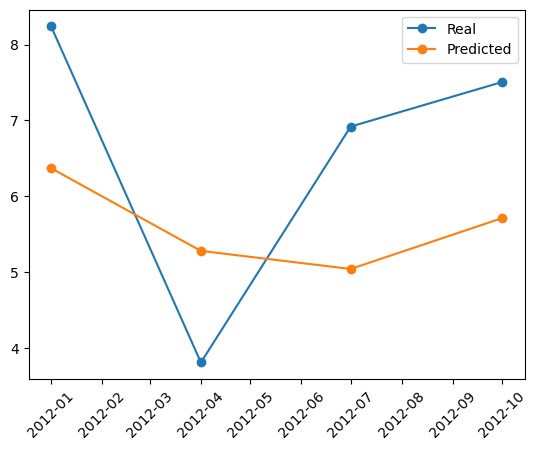

Реальный прирост за 2012 год: 29.15%
Прогнозный прирост за 2012 год: 24.35%



,Train,Test,Relative Difference
MAE,0.91,0.89,0.02
MSE,1.27,1.11,0.13
MAPE,55.85,22.20,0.60


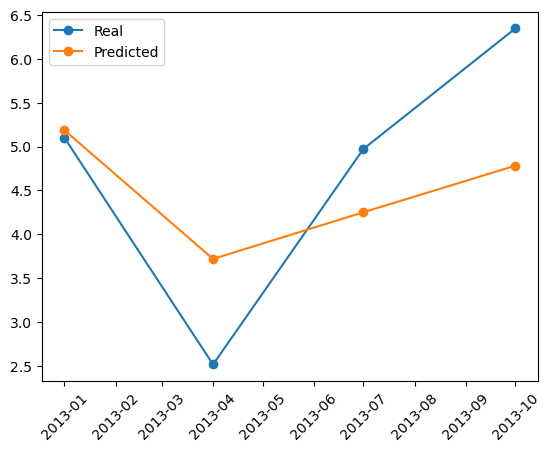

Реальный прирост за 2013 год: 20.28%
Прогнозный прирост за 2013 год: 19.17%



,Train,Test,Relative Difference
MAE,0.89,1.29,0.45
MSE,1.12,2.91,1.60
MAPE,60.00,47.40,0.21


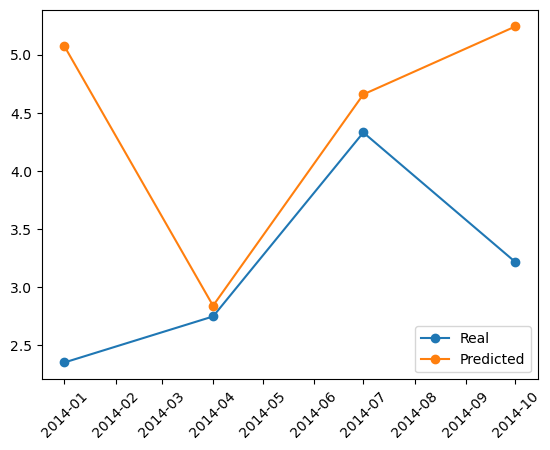

Реальный прирост за 2014 год: 13.25%
Прогнозный прирост за 2014 год: 19.02%



,Train,Test,Relative Difference
MAE,0.85,1.78,1.09
MSE,1.10,6.41,4.83
MAPE,60.80,85.80,0.41


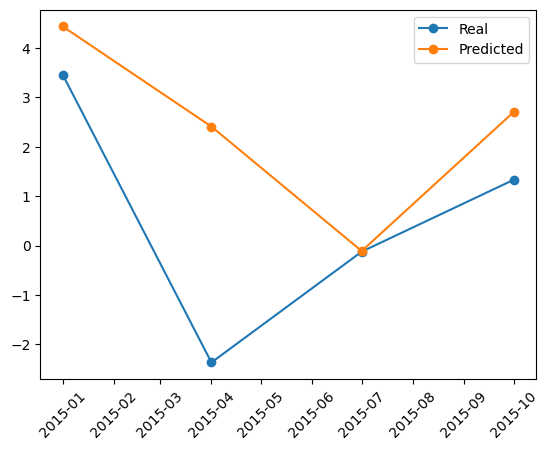

Реальный прирост за 2015 год: 2.23%
Прогнозный прирост за 2015 год: 9.72%



,Train,Test,Relative Difference
MAE,0.89,1.45,0.63
MSE,1.17,2.32,0.98
MAPE,37.81,389.64,9.31


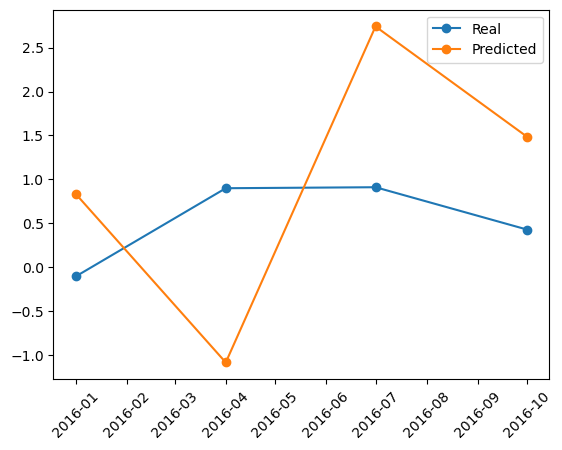

Реальный прирост за 2016 год: 2.14%
Прогнозный прирост за 2016 год: 3.99%



,Train,Test,Relative Difference
MAE,0.90,1.34,0.49
MSE,1.19,2.35,0.97
MAPE,43.60,90.14,1.07


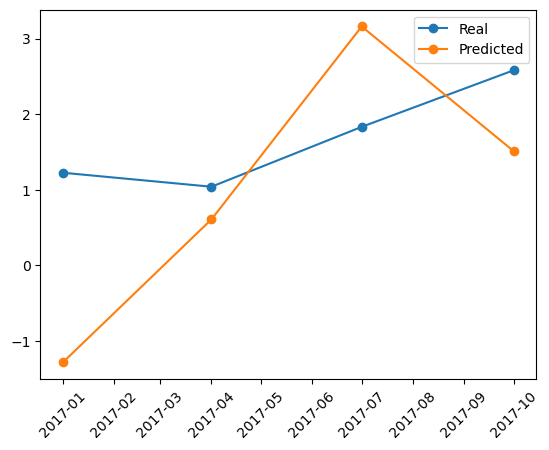

Реальный прирост за 2017 год: 6.84%
Прогнозный прирост за 2017 год: 4.0%



,Train,Test,Relative Difference
MAE,0.91,1.18,0.30
MSE,1.22,1.75,0.43
MAPE,52.99,33.98,0.36


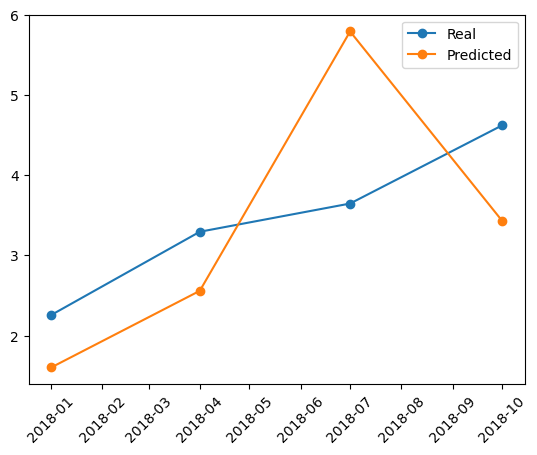

Реальный прирост за 2018 год: 14.54%
Прогнозный прирост за 2018 год: 14.02%



,Train,Test,Relative Difference
MAE,0.97,0.42,0.57
MSE,1.33,0.38,0.71
MAPE,58.82,14.09,0.76


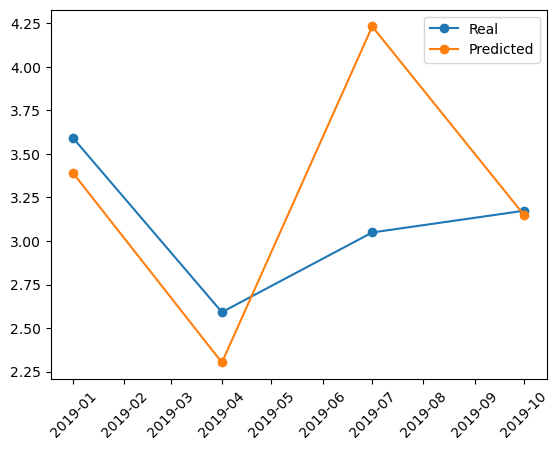

Реальный прирост за 2019 год: 12.99%
Прогнозный прирост за 2019 год: 13.72%



,Train,Test,Relative Difference
MAE,0.96,0.84,0.12
MSE,1.30,1.22,0.06
MAPE,56.54,22.80,0.60


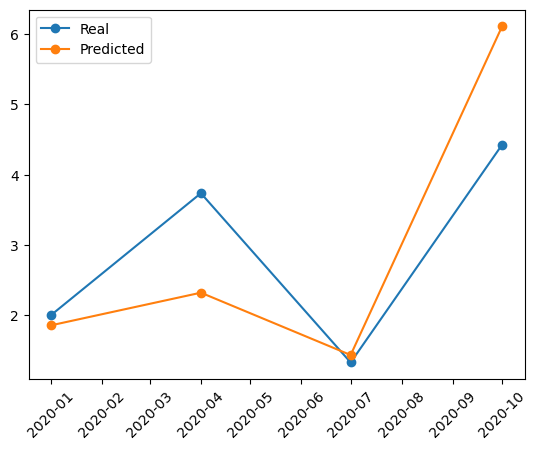

Реальный прирост за 2020 год: 11.97%
Прогнозный прирост за 2020 год: 12.18%



,Train,Test,Relative Difference
MAE,0.91,1.19,0.31
MSE,1.24,1.60,0.29
MAPE,61.30,38.43,0.37


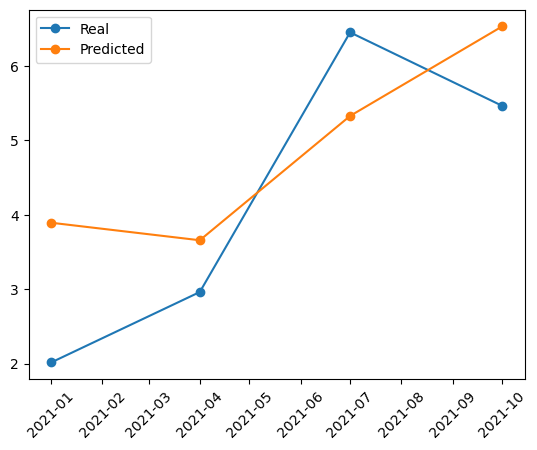

Реальный прирост за 2021 год: 17.92%
Прогнозный прирост за 2021 год: 20.84%



,Train,Test,Relative Difference
MAE,0.94,1.06,0.13
MSE,1.26,1.63,0.29
MAPE,57.76,40.20,0.30


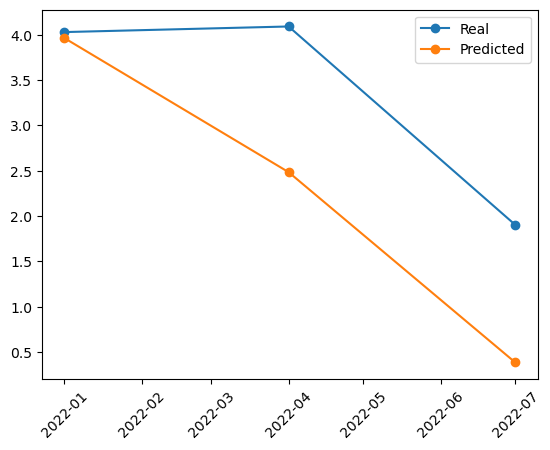

Реальный прирост за 2022 год: 10.35%
Прогнозный прирост за 2022 год: 6.96%

---------------------------------------------------------------------------
Средняя абсолютная ошибка по годовых прогнозам: 3.1%
Средняя относительная ошибка по годовых прогнозам: 51.18%
---------------------------------------------------------------------------
Медианная абсолютная ошибка по годовых прогнозам: 2.88%
Медианная относительная ошибка по годовых прогнозам: 20.7%
---------------------------------------------------------------------------


In [12]:
# Список признаков
feature_list_selected=['l1_target', 
                       'l1_rkpdh_volume', 
                        'gdp_volume', 
                        'l1_int_rate', 
                        'urals_price', 
                        'wages', 
                        'l1_ex_volume', 
                        'unempl_rate']
# Списки для заполнения
y_test_year_list=[]
y_test_pred_year_list=[]
quarter_pred_list=[]
# Прогоняем
for year in range(2011,2023):
    ## Выделяем train/test
    data_train=dataset_lr[(dataset_lr.period<f'{year}-01-01')|(dataset_lr.period>=f'{year}-12-31')]
    data_test=dataset_lr[(dataset_lr.period>=f'{year}-01-01')&(dataset_lr.period<f'{year}-12-31')]
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1)[feature_list_selected],data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1)[feature_list_selected],data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Добавляем для отчёта
    for pred in y_test_pred:
        quarter_pred_list.append(pred)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,y_test, label='Real',marker='o')
    plt.plot(data_test.period,y_test_pred, label='Predicted',marker='o')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()
    ## Агрегируем реальные и прогнозные значения
    y_test_year=prod(100+y_test)/(100**(len(y_test)-1))
    y_test_pred_year=prod(100+y_test_pred)/(100**(len(y_test_pred)-1))
    ## Добавляем в списки
    y_test_year_list.append(y_test_year-100)
    y_test_pred_year_list.append(y_test_pred_year-100)
    ## Выводим
    print(f'Реальный прирост за {year} год: {round((y_test_year-100),2)}%')
    print(f'Прогнозный прирост за {year} год: {round((y_test_pred_year-100),2)}%\n')
# Считаем метрики
mae=round(mean_absolute_error(y_test_year_list,y_test_pred_year_list),2)
mape=round(mean_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
medianae=round(median_absolute_error(y_test_year_list,y_test_pred_year_list),2)
medianape=round(median_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
# Итог
print('---------------------------------------------------------------------------')
print(f'Средняя абсолютная ошибка по годовых прогнозам: {mae}%')
print(f'Средняя относительная ошибка по годовых прогнозам: {mape}%')
print('---------------------------------------------------------------------------')
print(f'Медианная абсолютная ошибка по годовых прогнозам: {medianae}%')
print(f'Медианная относительная ошибка по годовых прогнозам: {medianape}%')
print('---------------------------------------------------------------------------')
# Формируем отчёт
metric_df.loc[len(metric_df)] = ['Линейная регрессия с отбором признаков без дамми-переменных',
                                 mae,mape,medianae,medianape,date_now]
year_predictions['y_true']=y_test_year_list
year_predictions['y_pred_linreg_selected_nodummy']=y_test_pred_year_list
quarter_predictions['y_pred_linreg_selected_nodummy']=quarter_pred_list

### 4. Линейная регрессия с "чёрными лебедями"

#### Добавляем дамми-переменные

In [13]:
# Суетные периоды
period_list=['2020-04-01','2022-04-01']
period_list_l1=['2020-01-01','2022-01-01']
period_list_dotacii=['2020-07-01','2021-01-01',]
period_list_dotacii_l1=['2020-04-01','2020-10-01'] 
# Дамми-переменные
dataset_lr['black_swan']=np.where(dataset_lr['period'].isin(period_list),1,0)
dataset_lr['l1_black_swan']=np.where(dataset_lr['period'].isin(period_list_l1),1,0)
dataset_lr['dotacii']=np.where(dataset_lr['period'].isin(period_list_dotacii),1,0)
dataset_lr['l1_dotacii']=np.where(dataset_lr['period'].isin(period_list_dotacii_l1),1,0)

#### На всех признаках

,Train,Test,Relative Difference
MAE,0.51,2.97,4.82
MSE,0.44,10.48,22.82
MAPE,38.26,47.98,0.25


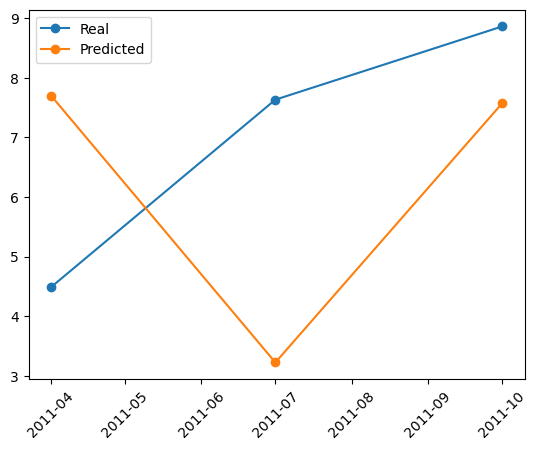

Реальный прирост за 2011 год: 22.43%
Прогнозный прирост за 2011 год: 19.59%



,Train,Test,Relative Difference
MAE,0.44,1.41,2.20
MSE,0.37,3.01,7.14
MAPE,25.90,20.14,0.22


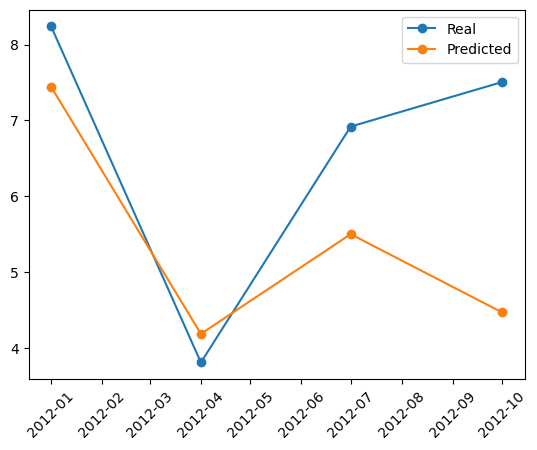

Реальный прирост за 2012 год: 29.15%
Прогнозный прирост за 2012 год: 23.37%



,Train,Test,Relative Difference
MAE,0.48,0.93,0.94
MSE,0.46,1.72,2.74
MAPE,26.05,24.32,0.07


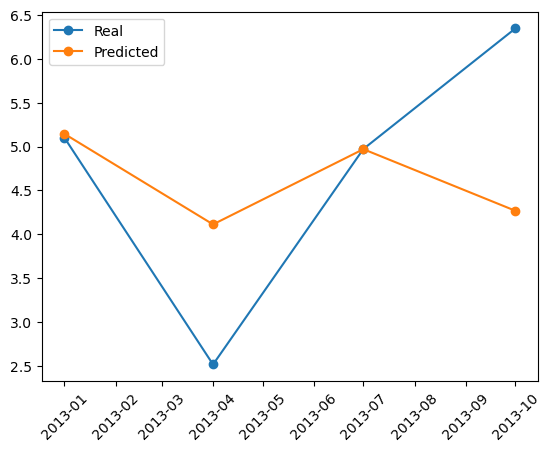

Реальный прирост за 2013 год: 20.28%
Прогнозный прирост за 2013 год: 19.81%



,Train,Test,Relative Difference
MAE,0.37,2.15,4.81
MSE,0.22,7.73,34.14
MAPE,27.19,65.93,1.42


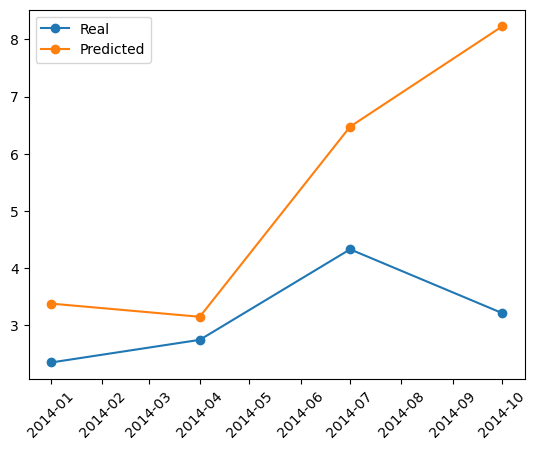

Реальный прирост за 2014 год: 13.25%
Прогнозный прирост за 2014 год: 22.88%



,Train,Test,Relative Difference
MAE,0.43,5.05,10.74
MSE,0.33,32.57,97.70
MAPE,24.64,1012.22,40.08


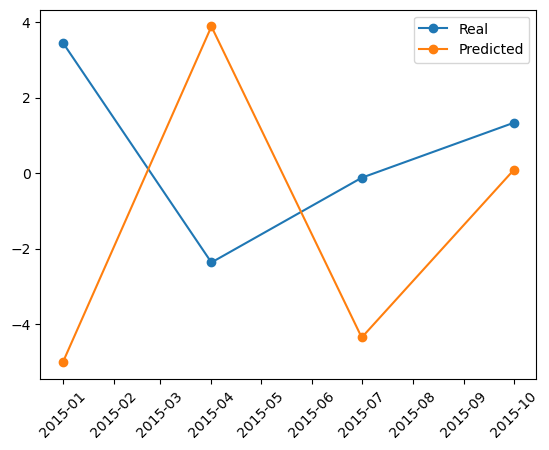

Реальный прирост за 2015 год: 2.23%
Прогнозный прирост за 2015 год: -5.55%



,Train,Test,Relative Difference
MAE,0.41,3.01,6.34
MSE,0.30,11.83,38.43
MAPE,13.30,933.95,69.22


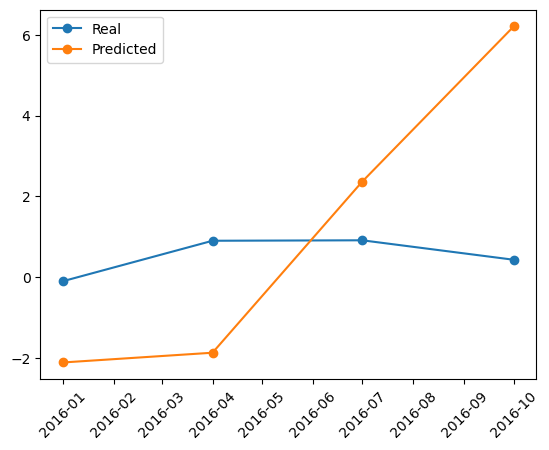

Реальный прирост за 2016 год: 2.14%
Прогнозный прирост за 2016 год: 4.42%



,Train,Test,Relative Difference
MAE,0.42,2.56,5.10
MSE,0.30,8.80,28.33
MAPE,36.24,191.12,4.27


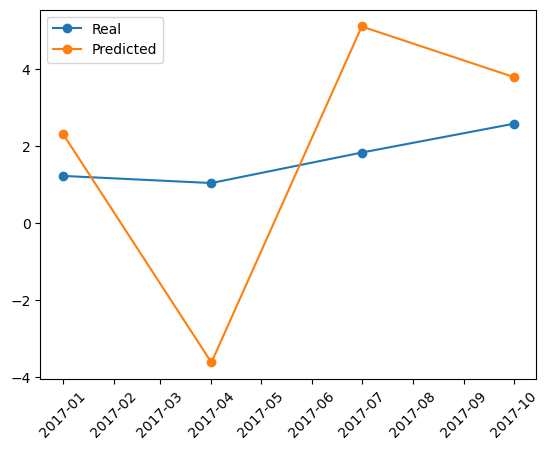

Реальный прирост за 2017 год: 6.84%
Прогнозный прирост за 2017 год: 7.59%



,Train,Test,Relative Difference
MAE,0.54,1.12,1.07
MSE,0.46,1.80,2.91
MAPE,37.51,36.53,0.03


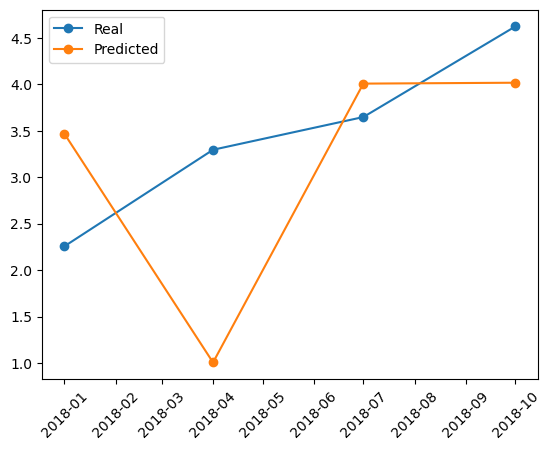

Реальный прирост за 2018 год: 14.54%
Прогнозный прирост за 2018 год: 13.06%



,Train,Test,Relative Difference
MAE,0.54,0.86,0.59
MSE,0.50,0.98,0.96
MAPE,40.24,27.88,0.31


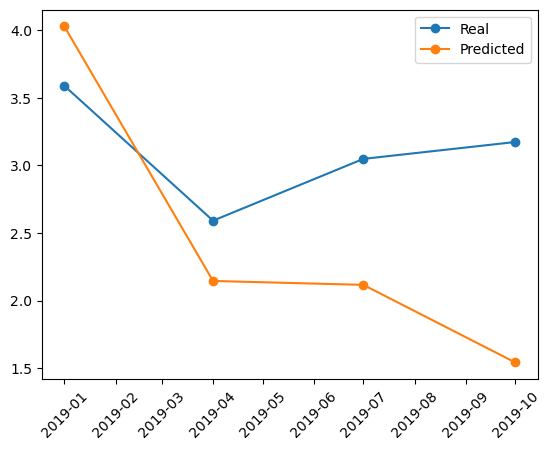

Реальный прирост за 2019 год: 12.99%
Прогнозный прирост за 2019 год: 10.18%



,Train,Test,Relative Difference
MAE,0.50,4.69,8.38
MSE,0.43,27.87,63.81
MAPE,25.89,162.33,5.27


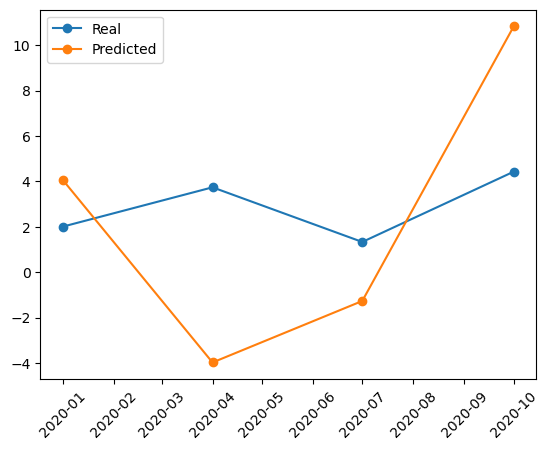

Реальный прирост за 2020 год: 11.97%
Прогнозный прирост за 2020 год: 9.33%



,Train,Test,Relative Difference
MAE,0.40,5.51,12.77
MSE,0.32,46.63,144.72
MAPE,43.07,209.65,3.87


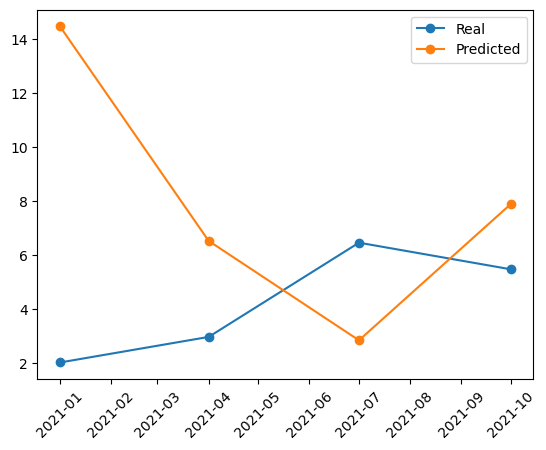

Реальный прирост за 2021 год: 17.92%
Прогнозный прирост за 2021 год: 35.27%



,Train,Test,Relative Difference
MAE,0.48,6.01,11.52
MSE,0.41,57.48,139.20
MAPE,29.19,178.20,5.10


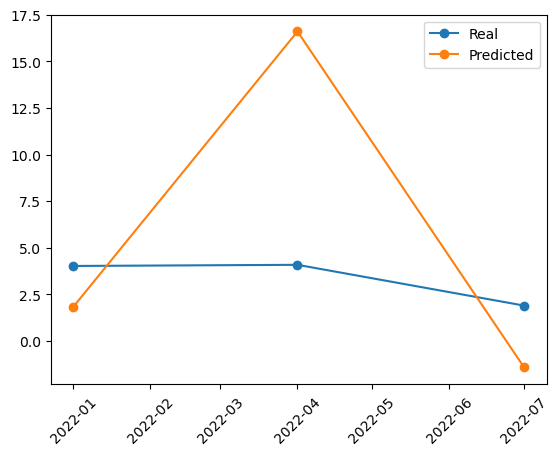

Реальный прирост за 2022 год: 10.35%
Прогнозный прирост за 2022 год: 17.07%

---------------------------------------------------------------------------
Средняя абсолютная ошибка по годовых прогнозам: 5.04%
Средняя относительная ошибка по годовых прогнозам: 65.77%
---------------------------------------------------------------------------
Медианная абсолютная ошибка по годовых прогнозам: 2.83%
Медианная относительная ошибка по годовых прогнозам: 21.84%
---------------------------------------------------------------------------


In [14]:
# Списки для заполнения
y_test_year_list=[]
y_test_pred_year_list=[]
quarter_pred_list=[]
# Прогоняем
for year in range(2011,2023):
    ## Выделяем train/test
    data_train=dataset_lr[(dataset_lr.period<f'{year}-01-01')|(dataset_lr.period>=f'{year}-12-31')]
    data_test=dataset_lr[(dataset_lr.period>=f'{year}-01-01')&(dataset_lr.period<f'{year}-12-31')]
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1),data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1),data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Добавляем для отчёта
    for pred in y_test_pred:
        quarter_pred_list.append(pred)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,y_test, label='Real',marker='o')
    plt.plot(data_test.period,y_test_pred, label='Predicted',marker='o')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()
    ## Агрегируем реальные и прогнозные значения
    y_test_year=prod(100+y_test)/(100**(len(y_test)-1))
    y_test_pred_year=prod(100+y_test_pred)/(100**(len(y_test_pred)-1))
    ## Добавляем в списки
    y_test_year_list.append(y_test_year-100)
    y_test_pred_year_list.append(y_test_pred_year-100)
    ## Выводим
    print(f'Реальный прирост за {year} год: {round((y_test_year-100),2)}%')
    print(f'Прогнозный прирост за {year} год: {round((y_test_pred_year-100),2)}%\n')
# Считаем метрики
mae=round(mean_absolute_error(y_test_year_list,y_test_pred_year_list),2)
mape=round(mean_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
medianae=round(median_absolute_error(y_test_year_list,y_test_pred_year_list),2)
medianape=round(median_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
# Итог
print('---------------------------------------------------------------------------')
print(f'Средняя абсолютная ошибка по годовых прогнозам: {mae}%')
print(f'Средняя относительная ошибка по годовых прогнозам: {mape}%')
print('---------------------------------------------------------------------------')
print(f'Медианная абсолютная ошибка по годовых прогнозам: {medianae}%')
print(f'Медианная относительная ошибка по годовых прогнозам: {medianape}%')
print('---------------------------------------------------------------------------')
# Формируем отчёт
metric_df.loc[len(metric_df)] = ['Линейная регрессия без отбора признаков с дамми-переменными',
                                 mae,mape,medianae,medianape,date_now]
year_predictions['y_true']=y_test_year_list
year_predictions['y_pred_linreg_full_dummy']=y_test_pred_year_list
quarter_predictions['y_pred_linreg_full_dummy']=quarter_pred_list

#### На отобранных признаках

,Train,Test,Relative Difference
MAE,0.86,1.63,0.90
MSE,1.15,3.19,1.77
MAPE,56.99,21.82,0.62


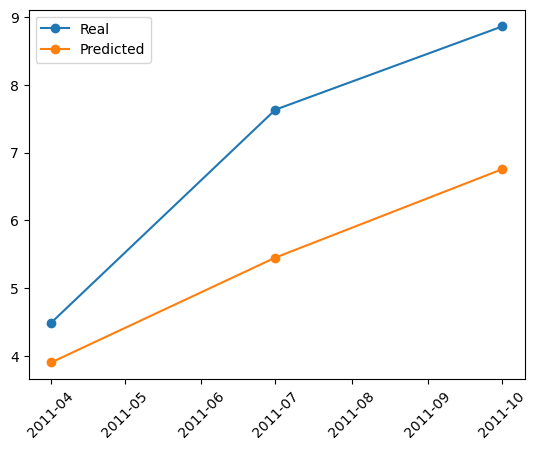

Реальный прирост за 2011 год: 22.43%
Прогнозный прирост за 2011 год: 16.96%



,Train,Test,Relative Difference
MAE,0.81,1.73,1.14
MSE,1.07,3.35,2.13
MAPE,45.43,31.14,0.31


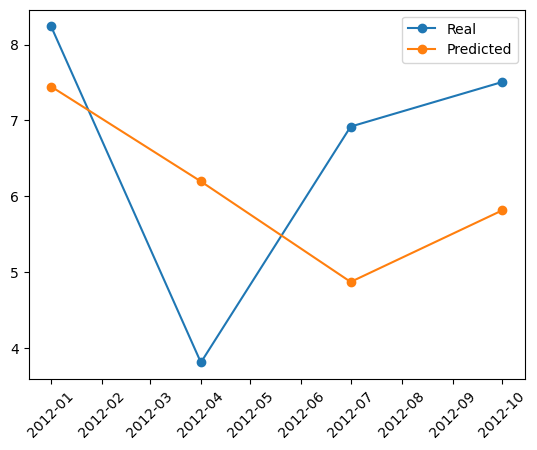

Реальный прирост за 2012 год: 29.15%
Прогнозный прирост за 2012 год: 26.62%



,Train,Test,Relative Difference
MAE,0.89,0.95,0.07
MSE,1.26,1.20,0.05
MAPE,51.24,19.10,0.63


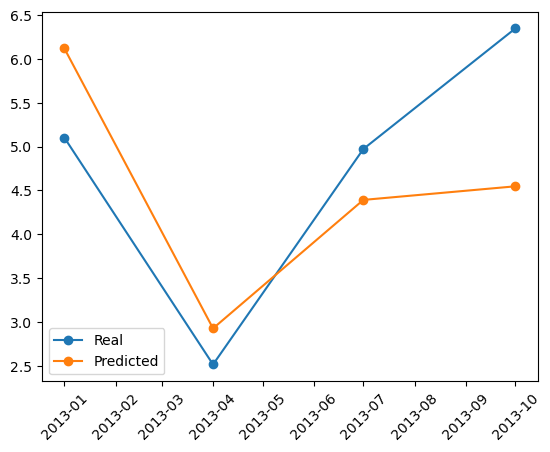

Реальный прирост за 2013 год: 20.28%
Прогнозный прирост за 2013 год: 19.2%



,Train,Test,Relative Difference
MAE,0.87,1.39,0.60
MSE,1.14,2.62,1.30
MAPE,49.72,51.86,0.04


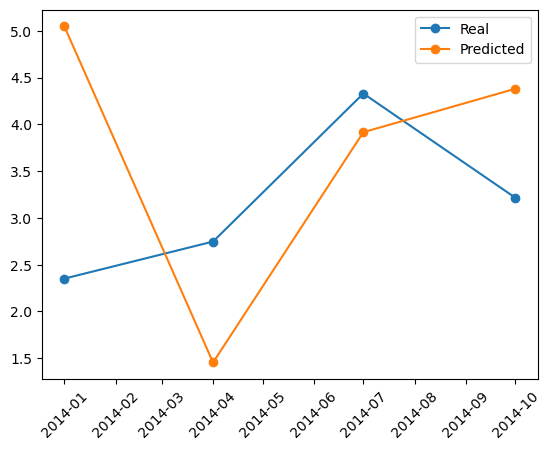

Реальный прирост за 2014 год: 13.25%
Прогнозный прирост за 2014 год: 15.6%



,Train,Test,Relative Difference
MAE,0.86,1.40,0.63
MSE,1.18,2.50,1.12
MAPE,37.93,205.94,4.43


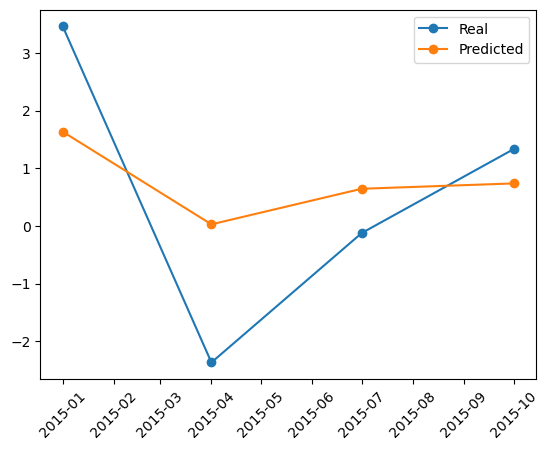

Реальный прирост за 2015 год: 2.23%
Прогнозный прирост за 2015 год: 3.07%



,Train,Test,Relative Difference
MAE,0.87,1.25,0.44
MSE,1.17,2.11,0.80
MAPE,39.56,197.62,4.00


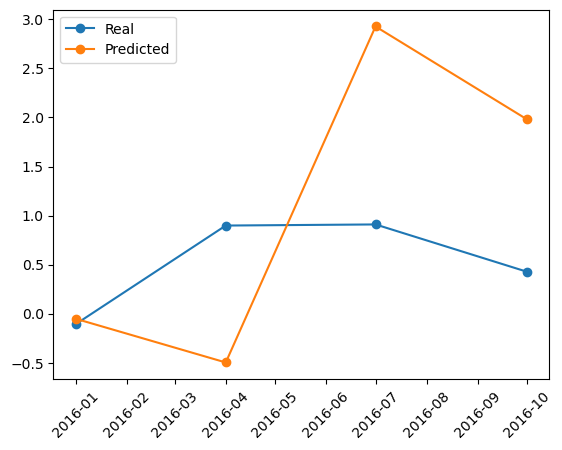

Реальный прирост за 2016 год: 2.14%
Прогнозный прирост за 2016 год: 4.39%



,Train,Test,Relative Difference
MAE,0.91,0.80,0.12
MSE,1.29,0.89,0.31
MAPE,52.65,51.53,0.02


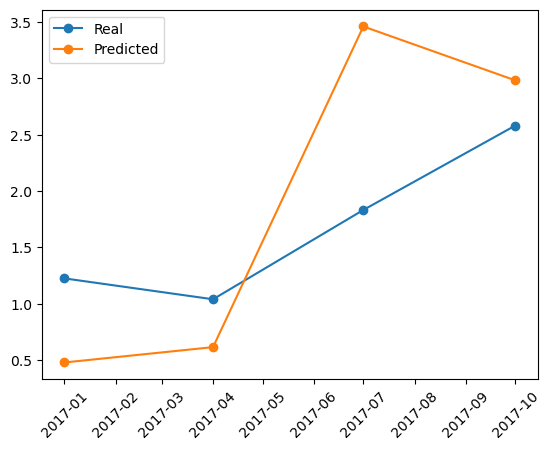

Реальный прирост за 2017 год: 6.84%
Прогнозный прирост за 2017 год: 7.71%



,Train,Test,Relative Difference
MAE,0.93,0.63,0.32
MSE,1.32,0.51,0.61
MAPE,53.60,19.39,0.64


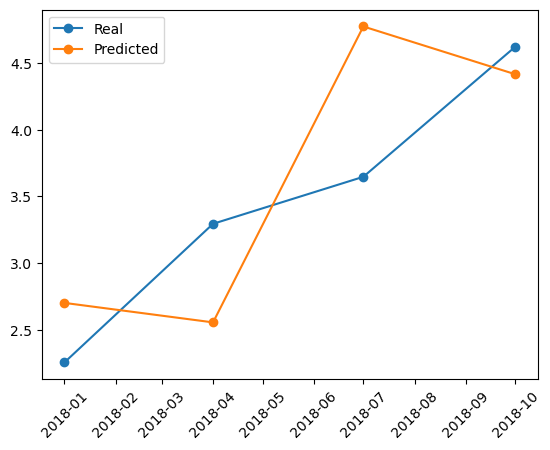

Реальный прирост за 2018 год: 14.54%
Прогнозный прирост за 2018 год: 15.23%



,Train,Test,Relative Difference
MAE,0.93,0.52,0.44
MSE,1.33,0.33,0.75
MAPE,52.69,16.74,0.68


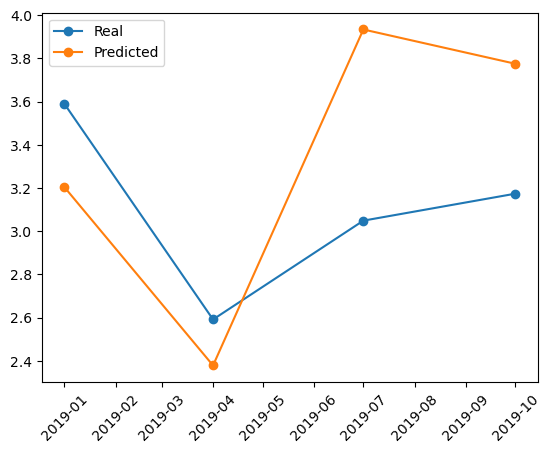

Реальный прирост за 2019 год: 12.99%
Прогнозный прирост за 2019 год: 13.96%



,Train,Test,Relative Difference
MAE,0.93,0.77,0.17
MSE,1.31,0.94,0.28
MAPE,56.97,26.58,0.53


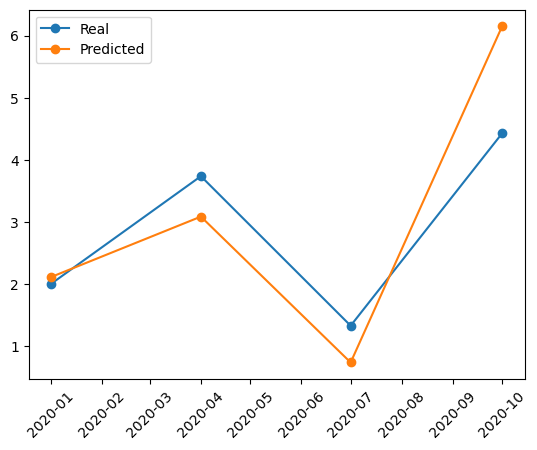

Реальный прирост за 2020 год: 11.97%
Прогнозный прирост за 2020 год: 12.56%



,Train,Test,Relative Difference
MAE,0.89,1.03,0.16
MSE,1.22,1.60,0.31
MAPE,46.48,20.80,0.55


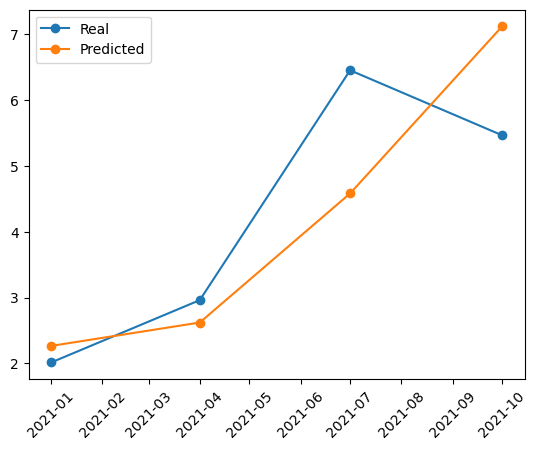

Реальный прирост за 2021 год: 17.92%
Прогнозный прирост за 2021 год: 17.56%



,Train,Test,Relative Difference
MAE,0.94,0.32,0.66
MSE,1.33,0.13,0.90
MAPE,51.90,9.07,0.83


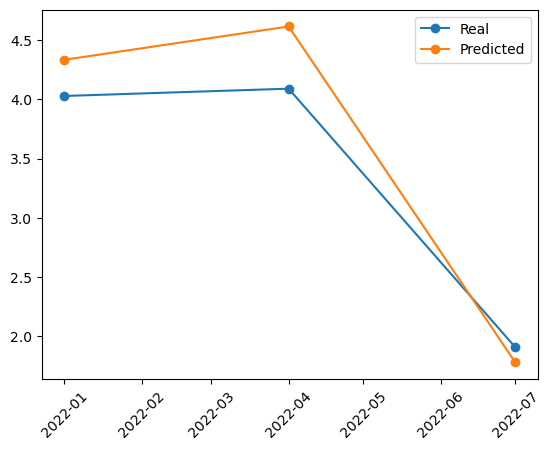

Реальный прирост за 2022 год: 10.35%
Прогнозный прирост за 2022 год: 11.09%

---------------------------------------------------------------------------
Средняя абсолютная ошибка по годовых прогнозам: 1.56%
Средняя относительная ошибка по годовых прогнозам: 19.82%
---------------------------------------------------------------------------
Медианная абсолютная ошибка по годовых прогнозам: 0.92%
Медианная относительная ошибка по годовых прогнозам: 8.09%
---------------------------------------------------------------------------


In [15]:
# Список признаков
feature_list_selected=['l1_target', 'l1_rkpdh_volume', 'gdp_volume', 'black_swan', 'cpi', 'vnok_volume', 'dotacii']
# Списки для заполнения
y_test_year_list=[]
y_test_pred_year_list=[]
quarter_pred_list=[]
# Прогоняем
for year in range(2011,2023):
    ## Выделяем train/test
    data_train=dataset_lr[(dataset_lr.period<f'{year}-01-01')|(dataset_lr.period>=f'{year}-12-31')]
    data_test=dataset_lr[(dataset_lr.period>=f'{year}-01-01')&(dataset_lr.period<f'{year}-12-31')]
    ## Выделяем X_train, X_test, y_train, y_test
    X_train,y_train=data_train.drop(['period','target'],axis=1)[feature_list_selected],data_train['target']
    X_test,y_test=data_test.drop(['period','target'],axis=1)[feature_list_selected],data_test['target']
    ## Строим модель
    model=LinearRegression().fit(X_train,y_train)
    ## Строим прогнозы
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)
    ## Добавляем для отчёта
    for pred in y_test_pred:
        quarter_pred_list.append(pred)
    ## Смотрим качество
    display(regression_report(y_train,y_train_pred,y_test,y_test_pred))
    ## Строим графики
    plt.plot(data_test.period,y_test, label='Real',marker='o')
    plt.plot(data_test.period,y_test_pred, label='Predicted',marker='o')
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()
    ## Агрегируем реальные и прогнозные значения
    y_test_year=prod(100+y_test)/(100**(len(y_test)-1))
    y_test_pred_year=prod(100+y_test_pred)/(100**(len(y_test_pred)-1))
    ## Добавляем в списки
    y_test_year_list.append(y_test_year-100)
    y_test_pred_year_list.append(y_test_pred_year-100)
    ## Выводим
    print(f'Реальный прирост за {year} год: {round((y_test_year-100),2)}%')
    print(f'Прогнозный прирост за {year} год: {round((y_test_pred_year-100),2)}%\n')
# Считаем метрики
mae=round(mean_absolute_error(y_test_year_list,y_test_pred_year_list),2)
mape=round(mean_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
medianae=round(median_absolute_error(y_test_year_list,y_test_pred_year_list),2)
medianape=round(median_absolute_percentage_error(y_test_year_list,y_test_pred_year_list)*100,2)
# Итог
print('---------------------------------------------------------------------------')
print(f'Средняя абсолютная ошибка по годовых прогнозам: {mae}%')
print(f'Средняя относительная ошибка по годовых прогнозам: {mape}%')
print('---------------------------------------------------------------------------')
print(f'Медианная абсолютная ошибка по годовых прогнозам: {medianae}%')
print(f'Медианная относительная ошибка по годовых прогнозам: {medianape}%')
print('---------------------------------------------------------------------------')
# Формируем отчёт
metric_df.loc[len(metric_df)] = ['Линейная регрессия с отбором признаков и дамми-переменными',
                                 mae,mape,medianae,medianape,date_now]
year_predictions['y_true']=y_test_year_list
year_predictions['y_pred_linreg_selected_dummy']=y_test_pred_year_list
quarter_predictions['y_pred_linreg_selected_dummy']=quarter_pred_list

### Сохраняем отчёты в эксель

In [17]:
year_predictions.to_excel('Годовые прогнозы.xlsx',index=0)
quarter_predictions.to_excel('Квартальные прогнозы.xlsx',index=0)
metric_df.to_excel('Метрики по годам.xlsx',index=0)